# Darshit Trevadia's Attempt to Evaluation Task

## Look into the dataset

# Data Cleaning
Since we want to data which is not properly structured we first clean our data for it to fit the structure of the given pre-existing model.

In [1]:
import csv 
import pandas as pd
# Change the path to the point where you have stored the files

filename ="./content/monojet_Zp2000.0_DM_50.0_chan3.csv"


event_dict = {}
lst = []

with open(filename, 'r') as data:
    i = 0
    for rows in data:
        events = rows.split(";") #splitting the row at ';' separator
        for event in events[5:]: # Skip the event ID, process ID, event weight, MET, METphi columns
            if event[0] == 'j':  # check for obj ID
                lst.append(event[2:]) 
        event_dict[i] = lst
        lst = []
        i += 1


count = 0
four_momentum = [ "E", "pt", "eta", "phi"]
property_dict = {} 

for event in event_dict.values():
    for i in range(0,len(event)):
        key = count + i/10.0 # Giving a unique ID to each obj of an event
        properties = [float(idx) for idx in event[i].split(',')]
        for prop in properties:
            property_dict[key] = properties
    count += 1


### Labeling the data 

In [2]:
df = pd.DataFrame(property_dict.items())
df = pd.DataFrame(df[1].to_list(), columns=four_momentum)
df_raw = df.copy()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.head())

          E        pt       eta      phi
0  258722.0  243675.0  0.328962  2.25014
1  520092.0  108590.0 -2.247300 -1.85679
2  383024.0   88405.6  2.145160 -1.95635
3   39507.6   35365.1  0.470460 -1.16445
4  225430.0   26878.2 -2.816080 -2.25938


# Working With The Data

Now that we have structured data at hand we get it ready for input

## Normalizing the Data

In [3]:
# custom_normalize() is defined corresponding to the custom_unnormalized() function. 
def custom_normalize(df):
    df['E'] = np.log10(df['E'])
    df['pt'] = np.log10(df['pt'])
    df['eta'] = df['eta'] / 5
    df['phi'] = df['phi'] / 3
    return df

Making training and tesing sets

In [4]:
import sklearn
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

df_scaled = custom_normalize(df)
print(df_scaled.head())

train, test = train_test_split(df_scaled, test_size=0.2, random_state=4, shuffle=True) #Note: Train and Test have normalized data


          E        pt       eta       phi
0  5.412833  5.386811  0.065792  0.750047
1  5.716080  5.035790 -0.449460 -0.618930
2  5.583226  4.946480  0.429032 -0.652117
3  4.596681  4.548575  0.094092 -0.388150
4  5.353012  4.429400 -0.563216 -0.753127


# Printing Data

In [5]:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
              E        pt       eta       phi
11617  5.263889  5.248902 -0.003008  0.010441
15629  5.070030  4.625729 -0.335054 -0.009473
11879  5.357687  4.517987  0.524074 -0.646643
10290  5.405123  5.354719  0.092444  1.037000
19751  5.708621  5.693264  0.051152  0.495497


Testing sample:
              E        pt       eta       phi
14034  5.628374  5.500614  0.157239 -0.150383
20948  5.784290  5.714161  0.111069 -0.978787
17203  5.240342  5.222134 -0.050020 -0.541510
8005   4.768635  4.743255 -0.061112  0.227999
10138  5.309507  4.754392  0.389814 -0.350323


The number of entries in the training data: 18128
The number of entries in the validation data: 4532


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

## Plotting Raw data plots

In [6]:
# import matplotlib.pyplot as plt

# variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

# branches=four_momentum

# n_bins = 100

# for kk in range(0,4):
#     n_hist_data, bin_edges, _ = plt.hist(df_raw[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
#     plt.xlabel(xlabel=variable_list[kk])
#     plt.ylabel('# of events')
#     plt.savefig("./raw_plots/raw_data_"+branches[kk],dpi=300)
#     plt.title(variable_list[kk]+" Raw Plot")
#     plt.show()

## Plotting Normalized data plots

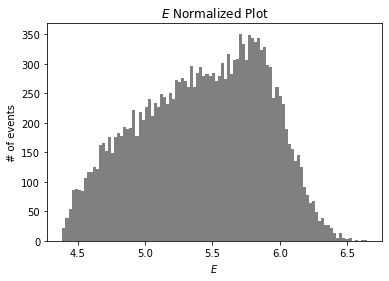

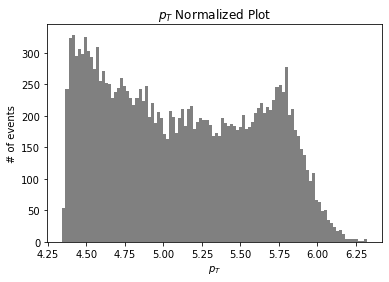

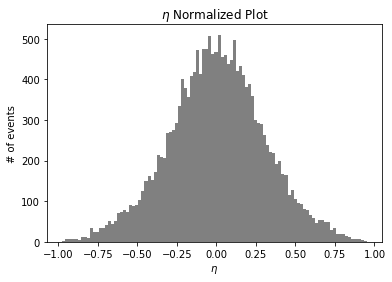

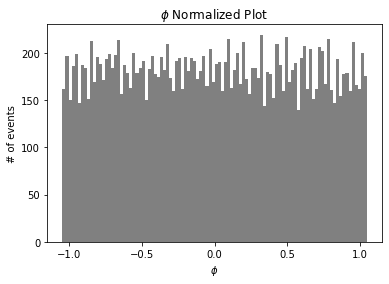

In [7]:
import matplotlib.pyplot as plt
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=four_momentum

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk])
    plt.ylabel('# of events')
    plt.savefig("./normalized_plots/four-momentum_train_normalized_"+branches[kk],dpi=300)
    plt.title(variable_list[kk]+" Normalized Plot")
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core


train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

/home/darshitt/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [9]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [10]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [11]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.017378008365631102
Learning rate with the steepest gradient: 0.0020892962347716093


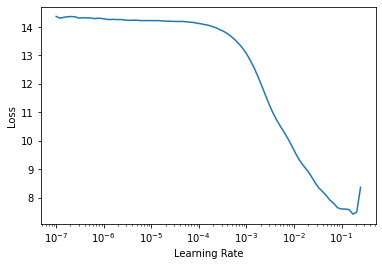

In [12]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [13]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100, lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 1.3340814113616943, 0.36856022477149963, '00:00']
[0, 1.3340814113616943, 0.36856022477149963, '00:00']
[1, 0.4550364017486572, 0.22696112096309662, '00:00']
[1, 0.4550364017486572, 0.22696112096309662, '00:00']
[2, 0.2799386978149414, 0.22779448330402374, '00:00']
[2, 0.2799386978149414, 0.22779448330402374, '00:00']
[3, 0.2404382824897766, 0.22767287492752075, '00:00']
[3, 0.2404382824897766, 0.22767287492752075, '00:00']
[4, 0.23146574199199677, 0.22817422449588776, '00:00']
[4, 0.23146574199199677, 0.22817422449588776, '00:00']
[5, 0.23052017390727997, 0.2281021624803543, '00:00']
[5, 0.23052017390727997, 0.2281021624803543, '00:00']
[6, 0.2335476130247116, 0.24204355478286743, '00:01']
[6, 0.2335476130247116, 0.24204355478286743, '00:01']
[7, 0.23296715319156647, 0.23217757046222687, '00:01']
[7, 0.23296715319156647, 0.23217757046222687, '00:01']
[8, 0.2338467240333557, 0.235432967543602, '00:00']
[8, 0.2338467240333557, 0.235432967543602, '00:00']
[9, 0.2350008487701416, 0.23

[73, 0.0008516180678270757, 0.0006824156153015792, '00:00']
[73, 0.0008516180678270757, 0.0006824156153015792, '00:00']
[74, 0.0010249793995171785, 0.0008200840675272048, '00:00']
[74, 0.0010249793995171785, 0.0008200840675272048, '00:00']
[75, 0.0006423676968552172, 0.00042695997399277985, '00:00']
[75, 0.0006423676968552172, 0.00042695997399277985, '00:00']
[76, 0.0005963259027339518, 0.0003436375118326396, '00:00']
[76, 0.0005963259027339518, 0.0003436375118326396, '00:00']
[77, 0.00047359903692267835, 0.00029284312040545046, '00:00']
[77, 0.00047359903692267835, 0.00029284312040545046, '00:00']
[78, 0.0004445366794243455, 0.00044612513738684356, '00:00']
[78, 0.0004445366794243455, 0.00044612513738684356, '00:00']
[79, 0.00038995122304186225, 0.00035306872450746596, '00:00']
[79, 0.00038995122304186225, 0.00035306872450746596, '00:00']
[80, 0.0003458804276306182, 0.00046416965778917074, '00:00']
[80, 0.0003458804276306182, 0.00046416965778917074, '00:00']
[81, 0.0003090582322329283

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

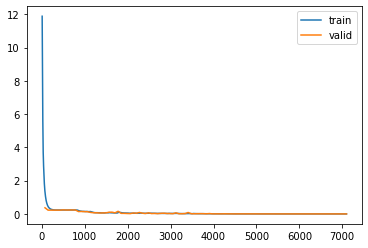

In [14]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [15]:
learn.validate()

(#1) [9.774785576155409e-05]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [16]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [17]:
def custom_unnormalize(df):
    df['E'] = 10**df['E']
    df['pt'] = 10**(df['pt'])
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    return df

Make the histograms from the dataset...

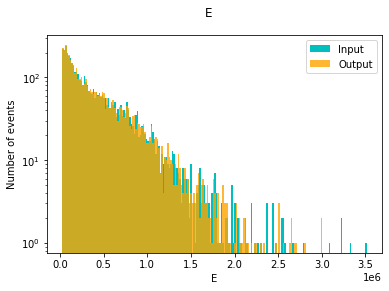

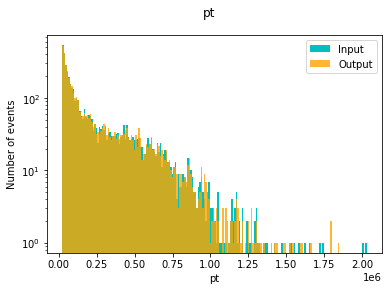

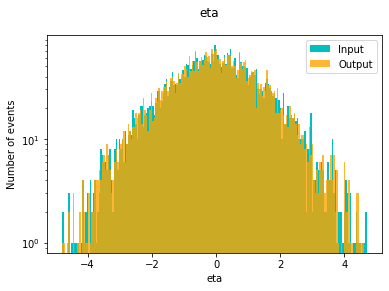

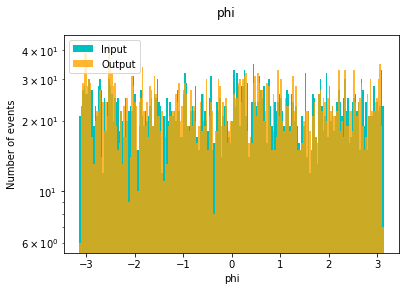

In [18]:
import numpy as np

plt.close('all')

variable_list = four_momentum
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    


alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(variable_list[kk])
    plt.xlabel(variable_list[kk])
    plt.ylabel('Number of events')

    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()